# Chapter 31: Working with Time Series

- Often we have date component in the index of a pandas series or dataframe because that allows us to do time aggregations easily

## 31.1 Loading the Data

In [3]:
import pandas as pd

url = 'https://github.com/mattharrison/datasets/raw/master'\
    '/data/dirtydevil.txt'
df = pd.read_csv(url, skiprows=lambda num: num <34 or num == 35,
                 sep='\t')

C:\Users\Joanna\AppData\Local\Temp\ipykernel_26504\3842608242.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, skiprows=lambda num: num <34 or num == 35,


In [4]:
df.head()

,agency_cd,site_no,datetime,tz_cd,144166_00060,144166_00060_cd,144167_00065,144167_00065_cd
0,USGS,9333500,2001-05-07 01:00,MDT,71.0,A:[91],NaN,NaN
1,USGS,9333500,2001-05-07 01:15,MDT,71.0,A:[91],NaN,NaN
2,USGS,9333500,2001-05-07 01:30,MDT,71.0,A:[91],NaN,NaN
3,USGS,9333500,2001-05-07 01:45,MDT,70.0,A:[91],NaN,NaN
4,USGS,9333500,2001-05-07 02:00,MDT,70.0,A:[91],NaN,NaN


In [5]:
def tweak_river(df_):
    return (df_
 .assign(datetime=pd.to_datetime(df_.datetime))
 .rename(columns={'144166_00060': 'cfs',
                  '144167_00065': 'gage_height'})
 .set_index('datetime')
)

In [7]:
dd = tweak_river(df)
dd

,agency_cd,site_no,tz_cd,cfs,144166_00060_cd,gage_height,144167_00065_cd
datetime,,,,,,,
2001-05-07 01:00:00,USGS,9333500,MDT,71.00,A:[91],NaN,NaN
2001-05-07 01:15:00,USGS,9333500,MDT,71.00,A:[91],NaN,NaN
2001-05-07 01:30:00,USGS,9333500,MDT,71.00,A:[91],NaN,NaN
2001-05-07 01:45:00,USGS,9333500,MDT,70.00,A:[91],NaN,NaN
2001-05-07 02:00:00,USGS,9333500,MDT,70.00,A:[91],NaN,NaN
...,...,...,...,...,...,...,...
2020-09-28 08:30:00,USGS,9333500,MDT,9.53,P,6.16,P
2020-09-28 08:45:00,USGS,9333500,MDT,9.20,P,6.15,P
2020-09-28 09:00:00,USGS,9333500,MDT,9.20,P,6.15,P


## 31.2 Adding Timezone Information

- Generally we should use ``pd.to_datetime`` to get a naive time and then convert the naive times to timezones with ``.dt.tz_localize``

In [10]:
def to_america_denver_time(df_, time_col, tz_col):
    return (df_
            .assign(**{tz_col: df_[tz_col].replace('MDT', 'MST7MDT')})
            .groupby(tz_col)
            [time_col]
            .transform(lambda s: pd.to_datetime(s)
                .dt.tz_localize(s.name, ambiguous=True)
                .dt.tz_convert('America/Denver'))
           )

In [11]:
def tweak_river(df_):
    return (df_
      .assign(datetime=to_america_denver_time(df_, 'datetime',
              'tz_cd'))
      .rename(columns={'144166_00060': 'cfs',
                       '144167_00065': 'gage_height'})
      .set_index('datetime')
     )

In [12]:
dd = tweak_river(df)

In [13]:
dd.head()

,agency_cd,site_no,tz_cd,cfs,144166_00060_cd,gage_height,144167_00065_cd
datetime,,,,,,,
2001-05-07 01:00:00-06:00,USGS,9333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 01:15:00-06:00,USGS,9333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 01:30:00-06:00,USGS,9333500,MDT,71.0,A:[91],NaN,NaN
2001-05-07 01:45:00-06:00,USGS,9333500,MDT,70.0,A:[91],NaN,NaN
2001-05-07 02:00:00-06:00,USGS,9333500,MDT,70.0,A:[91],NaN,NaN


## 31.3 Exploring the Data

<AxesSubplot: xlabel='datetime'>

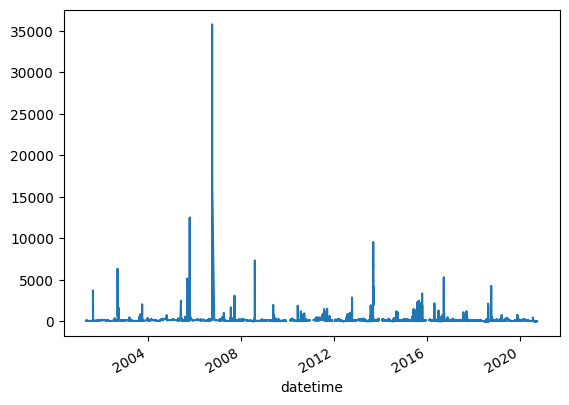

In [20]:
import matplotlib.pyplot as plt

dd.cfs.plot()

- From the visualization, there are some big outliers

<AxesSubplot: >

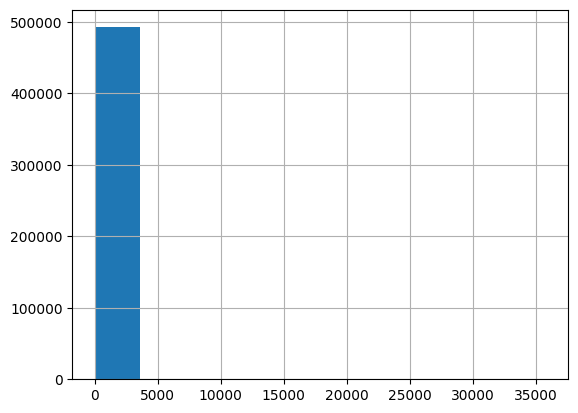

In [19]:
dd.cfs.hist()

## 31.4 Slicing Time Series

- The dataframe as datetime data in the index and we are able to perform slicing.

In [16]:
(dd
 .cfs
 .loc['2018':]
)

datetime
2018-01-01 00:00:00-07:00    92.80
2018-01-01 00:15:00-07:00    88.30
2018-01-01 00:30:00-07:00    90.50
2018-01-01 00:45:00-07:00    90.50
2018-01-01 01:00:00-07:00    94.00
                             ...  
2020-09-28 08:30:00-06:00     9.53
2020-09-28 08:45:00-06:00     9.20
2020-09-28 09:00:00-06:00     9.20
2020-09-28 09:15:00-06:00     9.20
2020-09-28 09:30:00-06:00     9.20
Name: cfs, Length: 95886, dtype: float64

<AxesSubplot: xlabel='datetime'>

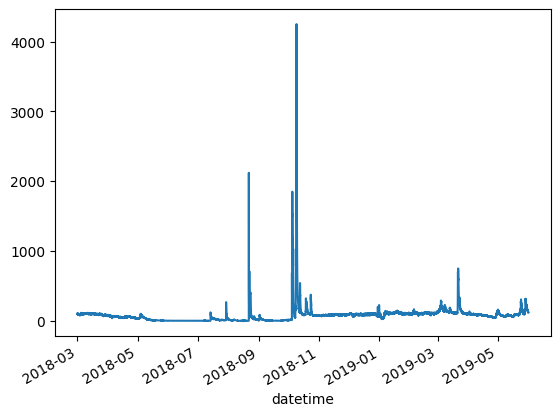

In [18]:
# include month
(dd
 .cfs
 .loc['2018/3':'2019/5']
 .plot()
)

<AxesSubplot: xlabel='datetime'>

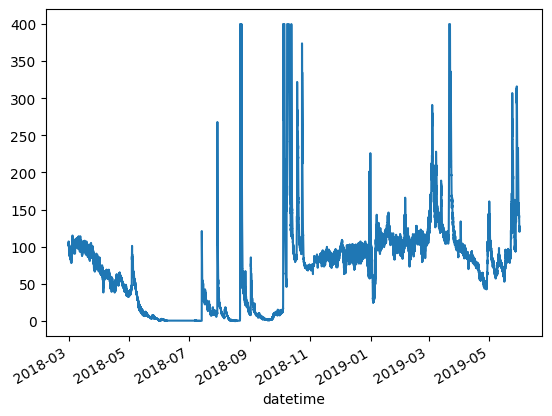

In [21]:
# clip upper limit to 400
(dd
 .cfs
 .loc['2018/3':'2019/5']
 .clip(upper=400)
 .plot()
)

- Leverage the ability to sample
- A common operation is to plot rolling 7-day average data on top of daily data

In [22]:
dd2018 = (dd
            .cfs
            .loc['2018/3':'2019/5']
            .clip(upper=400))

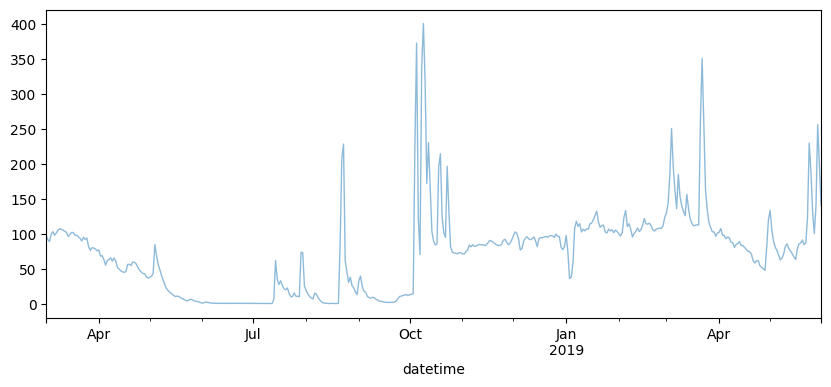

In [24]:
ax = (dd2018
      .resample('D')
      .mean()
      .plot(figsize=(10,4), alpha=0.5, linewidth=1, label='Daily')
)

In [37]:
(dd2018
      .resample('D')
      .mean()
      .rolling(7)
      .mean()
      .plot(figsize=(10,4), ax=ax, label='7-day Rolling')
      )

ax.legend()
ax.set_title("Dirty Devil Flow 2018 (cfs)")
